In [1]:
# library(Seurat)
library(dplyr)

library(ComplexHeatmap)
library(viridis)
library(circlize)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: viridisLite

circlize version 0.4.15
CRAN p

# Data load

In [2]:
load('../data/commons.rda', verbose = T)
load('../data/filter.list.rda', verbose=T)

subset.top <- readRDS('../data/subset.top.fun.rds')

Loading objects:
  cell.type.colors
  cell.types
  cell.types.nohighmito
  chr_df
  donor_sex
  fig
  flora_paper_list
  gene_type.df
  imprinted.df
  imprinted.genes
  monkey_paper_list
  monkey.genes
  monkey.markers
  nescreg.genes
  nescreg.genes.no_trg
  nescreg.genes.no_trg.early
  nescreg.list
  nescreg.list.no_trg
  nescreg.list.no_trg.early
  nescreg.markers
  nescreg.markers.no_trg
  nescreg.markers.no_trg.early
  nicola_marker_list
  origin_sex.colors
  pat.de
  pat.de.top20
  pat.list
  pat.neu.de
  pat.neu.de.top20
  pat.neu.list
  pat.neu.top20
  pat.top20
  phases
  phases.colors
  protein_coding.genes
  region.genes
  region.list
  region.markers
  samples
  samples.colors
  sex_chr.genes
  sex_chr.genes.x
  sex_chr.genes.y
  shown_2b_list
  shown_4d_list
  tf.genes
  tfs.df
  top100.sub.pat
  top100.subtype
  valid_chr
Loading objects:
  exp.filt.opts
  phase.filt.opts
  pval.filt.opts
  tf.filt.opts
  filt.grid
  filt.grid.desc


In [3]:
today_dir <- glue::glue('../plots/5e2_{Sys.Date()}/')

dir.create('../plots')
dir.create(today_dir)

Warning message in dir.create("../plots"):
“'../plots' already exists”


## Markers

In [4]:
int.levels <- c( 'D8_ASD_375&D8_ASD_384&D8_ASD_494', 'D8_ASD_375&D8_ASD_384', 'D8_ASD_375&D8_ASD_494', 'D8_ASD_384&D8_ASD_494', 'D8_ASD_375', 'D8_ASD_384', 'D8_ASD_494')

markers.donors <- data.table::fread('../results/selected_markers/markers_per_donor.nohighmito.with_filters_and_crossed.csv', data.table=F, drop = 1) %>% 
    mutate(
        anno_cluster_fct = factor(anno_cluster_fct, cell.types.nohighmito),
        matching.donors = factor(matching.donors, int.levels))
crossed.sub <- subset(markers.donors, filter.over.max)
crossed.sub.no_sex <- subset(markers.donors, filter.over.max & !in.sex_chr)
crossed.sub.no_sex.tf_only <- subset(markers.donors, filter.over.max & !in.sex_chr & gene.is.tf)

In [5]:
rge.ind.marker.df <- subset(markers.donors, filter.over.max & gene.is.tf & !in.sex_chr & (anno_cluster_fct=='RG early'))
rge.ind.marker.genes <- rge.ind.marker.df$gene


### Markers: per donor

## **single-cell**

### Markers: no high-mito

## **bulk data**

### Common

In [6]:
# Load bulk count matrix
bulk.tpm <- readRDS('~/codebases/ASD_bulk/BulkLines_TPM.rds')
bulk.raw <- readRDS('~/codebases/ASD_bulk/BulkLines_RAWcounts.rds')

# Log2 TPM
bulk.tpm[,-1] <- log2(bulk.tpm[,-1]+1)

#### metadata

In [7]:
# Load metadata
bulk.meta <- readRDS('~/codebases/ASD_bulk//Metadata.rds')
rownames(bulk.meta) <- bulk.meta$sample.ID

# Add metadata variables
# Rename columns/Factors
bulk.meta <- bulk.meta %>% mutate(
    experiment = ifelse(is.na(X20ng.ml.FGF2), 'DV', 'PA'),
    timepoint = readr::parse_number(Passage2),
    ExpStep = factor(Passage2, levels=unique(Passage2)), 
    FGF = readr::parse_number(X20ng.ml.FGF2),
    Condition=factor(Disease=='CNTR', levels=c('FALSE', 'TRUE'), labels=c('ASD','Ctrl')))

bulk.meta$test.name <- paste(bulk.meta$experiment, bulk.meta$timepoint, sep='_')
bulk.meta$test.name <- ifelse(bulk.meta$experiment == 'PA', 
                              paste(bulk.meta$test.name, gsub(as.character(bulk.meta$FGF), pattern='.', replacement='', fixed=T), sep='_'),
                              bulk.meta$test.name)
# Sort meta
bulk.meta <- bulk.meta %>% arrange(experiment, timepoint, desc(X20ng.ml.FGF2), desc(Disease), Line)

bulk.meta

,Line,Passage2,X20ng.ml.FGF2,sample.ID,Disease,experiment,timepoint,ExpStep,FGF,Condition,test.name
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>,<fct>,<chr>
S_A,290,DIV 8,NA,S_A,CNTR,DV,8,DIV 8,NA,Ctrl,DV_8
S_B,311,DIV 8,NA,S_B,CNTR,DV,8,DIV 8,NA,Ctrl,DV_8
S_C,317,DIV 8,NA,S_C,CNTR,DV,8,DIV 8,NA,Ctrl,DV_8
S_D,375,DIV 8,NA,S_D,ASD,DV,8,DIV 8,NA,ASD,DV_8
S_E,384,DIV 8,NA,S_E,ASD,DV,8,DIV 8,NA,ASD,DV_8
S_F,434,DIV 8,NA,S_F,ASD,DV,8,DIV 8,NA,ASD,DV_8
S_G,290,DIV 17,NA,S_G,CNTR,DV,17,DIV 17,NA,Ctrl,DV_17
S_H,311,DIV 17,NA,S_H,CNTR,DV,17,DIV 17,NA,Ctrl,DV_17
S_I,317,DIV 17,NA,S_I,CNTR,DV,17,DIV 17,NA,Ctrl,DV_17


#### genes

In [8]:
# Load gene metadata
bulk.genemeta <- readRDS('~/codebases/ASD_bulk/GeneInfo.rds') %>% dplyr::rename(GeneID=V1, GeneName=V2, GeneType=V3)
rownames(bulk.genemeta) <- bulk.genemeta$GeneID

# Deduplicate gene symbols
bulk.genemeta$tpm.sum <- rowSums(bulk.tpm[,-1])[bulk.genemeta$GeneID]
bulk.genemeta$raw.sum <- rowSums(bulk.raw[,-1])[bulk.genemeta$GeneID]

# subset(bulk.genemeta,
#        GeneName %in% GeneName[duplicated(GeneName)]) %>% arrange(GeneName,desc(raw.sum)) 


# This is also done in the Seurat function, decide where, probably here
# Keep only top expressed ID per Symbol
bulk.genemeta <- bulk.genemeta %>% arrange(desc(raw.sum)) %>% group_by(GeneName) %>% slice_head(n = 1)

# Reindex matrices
bulk.tpm <- bulk.tpm[bulk.genemeta$GeneID,]
bulk.raw <- bulk.raw[bulk.genemeta$GeneID,]

#### split

In [9]:
# Split metadata
bulk.meta.split <- split(bulk.meta,bulk.meta$experiment)
pass.meta <- bulk.meta.split[['PA']]
div.meta <- bulk.meta.split[['DV']]

In [10]:
# Split experiments
bulk.data.list <- list(
    'PA' = list(
        exp.raw = bulk.raw[, rownames(pass.meta)],
        exp.tpm = bulk.tpm[, rownames(pass.meta)],
        sample.meta = pass.meta,
        gene.meta = bulk.genemeta),
    'DV' = list(
        exp.raw = bulk.raw[, rownames(div.meta)],
        exp.tpm = bulk.tpm[, rownames(div.meta)],
        sample.meta = div.meta,
        gene.meta = bulk.genemeta)
)

### Bulk DEGs

In [11]:
# Load DE results
bulk.deg.file <- '~/codebases/ASD_bulk/BulkLinesDiffExpression.xlsx'
test.names <- openxlsx::getSheetNames(bulk.deg.file)
print(test.names)

# Open all sheets: conditions tested
bulk.dea.df <- do.call('rbind', lapply(test.names, function(sheet){
    
    df <- openxlsx::read.xlsx(bulk.deg.file, sheet = sheet, rowNames = F)
    colnames(df)[1] <- 'gene'
    df %>% mutate(test.name=sheet, 
                  geneID=sapply(gene, function(g) {strsplit(g, split='|', fixed=T)[[1]][1]}), 
                  geneSymbol=sapply(gene, function(g) {strsplit(g, split='|', fixed=T)[[1]][2]}))
    }))

# Gather log2FC for these genes and samples
bulk.dea.df.all <- bulk.dea.df
bulk.dea.df <- subset(bulk.dea.df, (test.name%in%unique(bulk.meta$test.name))&(geneID%in%bulk.genemeta$GeneID))

 [1] "DV_8"    "DV_17"   "DV_30"   "DV_38"   "PA_2_20" "PA_4_20" "PA_8_20"
 [8] "PA_2_01" "PA_4_01" "PA_8_01"


### Supplementary table 10

In [12]:
sorted.testnames <- c("DV_8",
"DV_17",
"DV_30",
"DV_38",
"PA_2_20",
"PA_2_01",
"PA_4_20",
"PA_4_01",
"PA_8_20",
"PA_8_01")

In [13]:
bulk.dea.df %>% 
    mutate(div_or_passage = factor(test.name, sorted.testnames),
           Up.in.ASD.or.control = plyr::mapvalues(sign(log2FoldChange), from=c(-1,0,1), to=c('Control', 'None', 'ASD'))) %>%

    arrange(div_or_passage, Up.in.ASD.or.control, desc(abs(log2FoldChange))) %>%
    select(gene, div_or_passage, baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, Up.in.ASD.or.control) -> dfs

split(dfs, ifelse(grepl('DV_', dfs$div_or_passage), 'Differentiation DEGs', 'Passaging DEGs')) %>% rev-> dfs

lapply(dfs, subset, padj <= 0.05) %>% setNames(nm=paste('Filtered', names(dfs))) %>% c(., dfs) -> dfs

openxlsx::write.xlsx(x = dfs, file = '../results/supp_table.10.bulk_differentiation_and_passaging_DEGs.xlsx')

In [14]:
# Get table of logFC
bulk.fc.table <- reshape2::dcast(bulk.dea.df, 'geneSymbol ~ test.name', value.var='log2FoldChange')
rownames(bulk.fc.table) <- bulk.fc.table$geneSymbol
bulk.fc.table$geneSymbol <- NULL
bulk.fc.table <- bulk.fc.table[,unique(bulk.meta$test.name)]
# Add rows for genes from single cell
# bulk.fc.table <- bulk.fc.table[sc.genes,]
# bulk.fc.table[is.na(bulk.fc.table)] <- 0
# rownames(bulk.fc.table) <- sc.genes


# Get table of p-vals
bulk.pval.table <- reshape2::dcast(bulk.dea.df, 'geneSymbol ~ test.name', value.var='padj')
rownames(bulk.pval.table) <- bulk.pval.table$geneSymbol
bulk.pval.table$geneSymbol <- NULL
bulk.pval.table <- bulk.pval.table[,unique(bulk.meta$test.name)]
# Add rows for genes from single cell
# bulk.pval.table <- bulk.pval.table[sc.genes,]
# bulk.pval.table[is.na(bulk.pval.table)] <- NA
# rownames(bulk.pval.table) <- sc.genes

# Turn p-vals into annotations
bulk.sig.table <- plyr::mapvalues(bulk.pval.table <= 0.05, c('TRUE', 'FALSE', NA), c('*', '', ''))


In [14]:
# Invert signs since it was computed the other way, with ASD as denominator
# bulk.fc.table <- bulk.fc.table*-1

## Seurat objects for bulk data

In [15]:
prepare.bulk.seurat <- function(
    raw,
    data = NULL,
    
    gene.meta, sample.meta,
    
    rm.zero.exp = T,
    only.genes = NULL,
    use.symbols = T,
    dedup.symbols = T
    
){
    require(Seurat)
    exp.r <- raw
    exp.t <- data
    smeta <- sample.meta
    gmeta <- gene.meta
    
    if (rm.zero.exp){
        # Filter 0 exp genes
        exp.genes <- rownames(exp.r)[rowSums(exp.r)>0]

        exp.r <- exp.r[rownames(exp.r)%in%exp.genes,]
        exp.t <- exp.t[rownames(exp.t)%in%exp.genes,]

        gmeta <- subset(gmeta, GeneID %in%exp.genes)
    }
    
    # Filter out genes not in list 
    if (!is.null(only.genes)){
        
        gmeta <- subset(gmeta, GeneName %in%only.genes)

        exp.r <- exp.r[rownames(exp.r)%in%gmeta$GeneID,]
        exp.t <- exp.t[rownames(exp.t)%in%gmeta$GeneID,]
    }
    
    # Deduplicate gene symbols keeping gene with highest expression
    if (dedup.symbols){
        gmeta <- gmeta %>% mutate(countSum=rowSums(exp.r[GeneID,])) %>% group_by(GeneName) %>% mutate(dup.rank = order(countSum, decreasing = T)) %>% ungroup()

        gmeta <- subset(gmeta, dup.rank == 1)

        exp.r <- exp.r[rownames(exp.r)%in%gmeta$GeneID,]
        exp.t <- exp.t[rownames(exp.t)%in%gmeta$GeneID,]
    }
    
    # Rename gene ids to symbols
    if(use.symbols){
        rownames(exp.r) <- plyr::mapvalues(x=rownames(exp.r),
                                             from=gmeta$GeneID,
                                             to=gmeta$GeneName)
        rownames(exp.t) <- plyr::mapvalues(x=rownames(exp.t),
                                             from=gmeta$GeneID,
                                             to=gmeta$GeneName)
    }
    
    # Add 0 values for missing genes

    if (!is.null(only.genes)){        
        
        exp.r <- exp.r[only.genes,]
        rownames(exp.r) <- only.genes
        exp.r[is.na(exp.r)] <- 0

        exp.t <- exp.t[only.genes,]
        rownames(exp.t) <- only.genes
        exp.t[is.na(exp.t)] <- 0
    }
    
    # Create seurat
    bulk.seu <- CreateSeuratObject(counts = exp.r, 
                                   # data=exp.t, 
                                   assay = 'RNA',
                                   meta.data = smeta,
                                   min.cells = 0, min.features = 0)
    bulk.seu[['RNA']]@data <- as.matrix(exp.t)
    # Fill scale.data
    bulk.seu[['RNA']]@scale.data <- apply(
        exp.t, 1, function(x){
            if (all(x==0)){x}else{setNames(scales::rescale_max(x), names(x))}}
    ) %>% t() %>% as.matrix()
    
    return(bulk.seu)
    
}

In [16]:
bulk.seurats <- lapply(names(bulk.data.list),
                      function(ex){
                          bdata <- bulk.data.list[[ex]]
                          prepare.bulk.seurat(
                              raw = bdata$exp.raw,
                              data = bdata$exp.tpm,
                              sample.meta = bdata$sample.meta,
                              dedup.symbols=F, 
                              gene.meta = bdata$gene.meta
                              # only.genes = sc.genes
                          )})
names(bulk.seurats) <- names(bulk.data.list)

Loading required package: Seurat

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot 

In [17]:
bulk.seurats

$PA
An object of class Seurat 
45072 features across 36 samples within 1 assay 
Active assay: RNA (45072 features, 0 variable features)
 3 layers present: counts, data, scale.data

$DV
An object of class Seurat 
45112 features across 24 samples within 1 assay 
Active assay: RNA (45112 features, 0 variable features)
 3 layers present: counts, data, scale.data


In [18]:
suppressPackageStartupMessages(library(DESeq2))
dv.dds <- readRDS('~/codebases/ASD_bulk/DDS.DV.rds')
dv.rld <- DESeq2::vst(dv.dds)

pa.dds <- readRDS('~/codebases/ASD_bulk/DDS.PA.rds')
pa.rld <- DESeq2::vst(pa.dds)

#### Meta for htmp

In [19]:
order_rows <- function(mat, n.bins=10, axis=2){
    if (axis == 2){
        apply(mat, 2, function(x){cut(-x, breaks = n.bins) %>% as.numeric}) %>% 
            as.data.frame(row.names = rownames(mat))%>%
            arrange_all%>%rownames() %>%
        return()
    } else {
        apply(mat, 1, function(x){cut(-x, breaks = n.bins) %>% as.numeric}) %>% t() %>%
            as.data.frame()%>%
            arrange_all%>%rownames() %>%
        return()
    }
}

In [20]:
lines <- setNames(
    sapply(strsplit(names(samples.colors), split='_', fixed=T), function(x)paste(x[-1], collapse=' ')),
    sapply(strsplit(names(samples.colors), split='_', fixed=T), function(x)x[3]))
           

DV_cols <- setNames(rev(rev(RColorBrewer::brewer.pal('RdPu', n=6)[-1])[-1]), c('DIV 8', 'DIV 17', 'DIV 30', 'DIV 38'))
# PA_cols <- setNames(rev(rev(RColorBrewer::brewer.pal('PuBu', n=5)[-1])[-1]), c('Passage2','Passage4','Passage8'))
PA_cols <- c('Passage2 20'='#006D2C','Passage4 20'='#A50F15','Passage8 20'='#252525',
             'Passage2 0.1'='#BAE4B3','Passage4 0.1'='#FCAE91','Passage8 0.1'='#CCCCCC')

meta.cols <- list(
    Condition=c('ASD'='orangered2', 'Ctrl'='#0981D1'),
    # Experiment=c(
    #     'PA'=rev(RColorBrewer::brewer.pal('PuBu', n=8))[3],
    #     'DV' = rev(RColorBrewer::brewer.pal('RdPu', n=8))[3]),
    Experiment=c(
        'PA'='lightgreen',
        'DV' ='gold'),
    Step=c(DV_cols, PA_cols),
    Passaging=PA_cols,
    Differentiation=DV_cols,
    FGF = c('20'='#1F1F1F', '0.1'='#BABABA'),
    Line=setNames(samples.colors, lines)
)

In [21]:
bulk.meta %>% arrange(ExpStep, desc(FGF), Condition, Line) %>% rownames -> sorted.samples
bulk.meta <- bulk.meta[sorted.samples, ]

exp.meta <- bulk.meta[sorted.samples,] %>% select(experiment, ExpStep, FGF, Line, Condition, test.name) %>%
    mutate_all(function(x){if(is.numeric(x)){as.character(x)}else{x}}) %>% 
    mutate(Step=ExpStep, Experiment=experiment,ExpStep=NULL,experiment=NULL ) %>% 
    mutate(Step=ifelse(Experiment=='PA', paste(as.character(Step), FGF), as.character(Step)), 
           Step=factor(Step, levels=unique(Step)),
           FGF=NULL, 
           Line=gsub(x=Line, pattern='434', replacement='494'),
           Line=factor(lines[Line], lines)) %>% 
    select(test.name, Experiment, Step, Line) 

mat.meta <- unique(exp.meta%>%mutate(Line=NULL, Condition=NULL))
rownames(mat.meta) <- mat.meta$test.name
mat.meta$test.name <- NULL

pa.mat.meta <- subset(mat.meta, Experiment == 'PA') %>% dplyr::rename(Passaging=Step)
dv.mat.meta <- subset(mat.meta, Experiment == 'DV') %>% dplyr::rename(Differentiation=Step)
pa.meta <- subset(exp.meta, Experiment == 'PA') %>% dplyr::rename(Passaging=Step)%>% mutate(test.name=NULL)
dv.meta <- subset(exp.meta, Experiment == 'DV') %>% dplyr::rename(Differentiation=Step)%>% mutate(test.name=NULL)

#### Def genes

In [22]:
# genes <- subset(sc.dea.df, (p_val_adj < 0.05) & gene.is.tf & filter.2of3.over.2of3 & !in.sex_chr)$gene %>% unique()
# genes <- subset(markers.donors, gene.is.tf)$gene %>% unique()
genes <- sort(rge.ind.marker.genes)

all(genes%in%rownames(bulk.fc.table))
length(genes)

valid.genes <- genes # only significant: genes[genes%in%rownames(bulk.sig.table)[rowSums(bulk.sig.table!='')!=0 ]]

smat <- bulk.sig.table[genes,rownames(mat.meta)]
mat <- as.matrix(bulk.fc.table[valid.genes, rownames(mat.meta)])

[1] TRUE

[1] 23

In [23]:
mat

,PA_2_20,PA_2_01,PA_4_20,PA_4_01,PA_8_20,PA_8_01,DV_8,DV_17,DV_30,DV_38
DMRTA1,-0.32902143,-0.2547414,0.84184135,0.9161214,0.12259939,0.19687945,-0.24933358,-0.46343611,-0.65882981,-0.74718896
EGR1,0.57407122,-0.1319549,0.09421314,-0.6118129,2.40773232,1.70170624,-0.10785768,-0.60488822,0.04504802,0.81745055
EMX2,0.24329974,0.2606112,0.17486186,0.1921733,1.70850637,1.72581778,-2.03854381,-1.20893533,-0.67958528,-1.15699077
FEZF2,-0.38366907,-0.3723914,0.54131748,0.5525951,0.89075611,0.90203376,-0.41295257,-0.06610991,-0.94543869,-1.14083966
FOXB1,-1.11317037,-1.2369058,1.06591080,0.9421753,-1.24730335,-1.37103881,-1.20172329,-0.30552272,-1.25346356,-1.26213249
FOXG1,2.29609231,2.6870313,1.88895661,2.2798956,2.35320960,2.74414858,3.71274008,1.24265118,1.22572079,1.34483387
HES1,0.50704323,0.2180123,0.52788015,0.2388492,0.24732834,-0.04170262,0.47073952,0.52461036,0.44786149,0.75283394
HES4,0.45194581,0.2211811,1.50576202,1.2749973,-0.03108490,-0.26184965,0.59074432,0.81406307,0.22735202,-0.16226058
HES5,1.66871056,1.0115631,2.20557038,1.5484229,-0.74724132,-1.40438880,0.49567209,0.77926958,-0.02678524,0.58450197
LHX2,1.10119977,0.6802226,1.04023063,0.6192535,1.66566902,1.24469185,1.62216685,0.09927040,-0.14389375,-0.29017859


In [24]:
pa.lfc <- mat[, rownames(pa.mat.meta)]
dv.lfc <- mat[, rownames(dv.mat.meta)]

### Conf matrix

In [25]:
subset(rge.ind.marker.df, gene%in%valid.genes)[,c('gene', 'matching.donors', 'overexpressed.in')]

,gene,matching.donors,overexpressed.in
,<chr>,<fct>,<chr>
226452,PEG3,D8_ASD_375,Ctrl
226503,DMRTA1,D8_ASD_384,Ctrl
226506,EGR1,D8_ASD_384,Ctrl
226512,EMX2,D8_ASD_384,Ctrl
226519,FEZF2,D8_ASD_384,Ctrl
226523,FOXB1,D8_ASD_384,Ctrl
226526,FOXG1,D8_ASD_384,ASD
226534,HES1,D8_ASD_384,ASD
226556,LHX2,D8_ASD_384,ASD


In [26]:
unique(subset(rge.ind.marker.df, gene%in%valid.genes)[,c('gene', 'matching.donors', 'overexpressed.in')]) %>% tidyr::separate_rows('matching.donors', sep = '&') %>% reshape2::dcast('gene ~ matching.donors', fun.aggregate = function(x){
    if (length(x)==0) 'None' else{paste(sort(unique(x)), collapse=' ')}}) -> confusion.matrix

rownames(confusion.matrix) <- confusion.matrix$gene
confusion.matrix$gene <- NULL
confusion.matrix <- confusion.matrix[valid.genes, ]

Using overexpressed.in as value column: use value.var to override.



### Htmp

### Htmp + exp

In [27]:
# expression, from DESeq2::vst
pa.mat <- assay(pa.rld)[sapply(valid.genes, function(x){grepl(pattern=x, x=rownames(pa.rld))})%>%rowSums()%>%as.logical,]
rownames(pa.mat) <- strsplit(rownames(pa.mat), split='|', fixed=T) %>% sapply(function(x){x[2]}) %>% make.unique()
pa.mat <- pa.mat[valid.genes, rownames(pa.meta)]
# bulk.seurats$PA[['RNA']]@scale.data[valid.genes,]

dv.mat <- assay(dv.rld)[sapply(valid.genes, function(x){grepl(pattern=x, x=rownames(dv.rld))})%>%rowSums()%>%as.logical,]
rownames(dv.mat) <- strsplit(rownames(dv.mat), split='|', fixed=T) %>% sapply(function(x){x[2]}) %>% make.unique()
dv.mat <- dv.mat[valid.genes, rownames(dv.meta)] 
# bulk.seurats$DV[['RNA']]@scale.data[valid.genes,]

### Order

In [28]:
rng <- range(mat)
col <- colorRamp2(breaks = c(rng[1], 0, rng[2]), colors = c('Blue', 'lightyellow', 'Red'))

mat <- mat[valid.genes,]
smat <- smat[valid.genes,]
pa.lfc <- pa.lfc[valid.genes,]
dv.lfc <- dv.lfc[valid.genes,]
pa.smat <- smat[valid.genes,colnames(pa.lfc)]
dv.smat <- smat[valid.genes,colnames(dv.lfc)]
pa.mat <- pa.mat[valid.genes,]
dv.mat <- dv.mat[valid.genes,]
confusion.matrix <- confusion.matrix[valid.genes,]

topa.pa <- HeatmapAnnotation(df = pa.mat.meta[,colnames(pa.mat.meta)!='Experiment', drop=F],
                             na_col = 'white', col = meta.cols, show_annotation_name = F)
topa.dv <- HeatmapAnnotation(df = dv.mat.meta[,colnames(dv.mat.meta)!='Experiment', drop=F],
                             na_col = 'white', col = meta.cols, show_annotation_name = F)

bottoma.pa <- HeatmapAnnotation(df = pa.mat.meta[,colnames(pa.mat.meta)=='Experiment', drop=F],
                                na_col = 'white', col = meta.cols, show_annotation_name = T,
                                annotation_name_side = 'left')
bottoma.dv <- HeatmapAnnotation(df = dv.mat.meta[,colnames(dv.mat.meta)=='Experiment', drop=F],
                                na_col = 'white', col = meta.cols, show_annotation_name = F)

topb.pa <- HeatmapAnnotation(df = pa.meta[,colnames(pa.meta)!='Experiment', drop=F], 
                             show_annotation_name = F,  na_col = 'white', col = meta.cols)
topb.dv <- HeatmapAnnotation(df = dv.meta[,colnames(dv.meta)!='Experiment', drop=F], 
                             show_annotation_name = F, na_col = 'white', col = meta.cols,
                             annotation_name_side = 'right')

bottomb.pa <- HeatmapAnnotation(df = pa.meta[,colnames(pa.meta)=='Experiment', drop=F], 
                             show_annotation_name = F,  na_col = 'white', col = meta.cols,
                             annotation_name_side = 'left')
bottomb.dv <- HeatmapAnnotation(df = dv.meta[,colnames(dv.meta)=='Experiment', drop=F], 
                             show_annotation_name = F, na_col = 'white', col = meta.cols,
                             annotation_name_side = 'right')



orders <- list(
    'ASD/Ctrl expression bias\n(in Passaging experiment)' = order_rows(pa.lfc),
    'Gene expression\n(in Passaging experiment)' = order_rows(pa.mat, n.bins = 20),
    'ASD/Ctrl expression bias\n(in Differentiation experiment)' = order_rows(dv.lfc),
    'Gene expression\n(in Differentiation experiment)' = order_rows(dv.mat, n.bins = 20)
    # 'ASD/Ctrl expression bias\n(in both experiments)' = order_rows(mat),
    # 'Gene expression\n(in both experiments)' = order_rows(cbind(pa.mat, dv.mat), n.bins = 20),
)



'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“Note: not all columns in the data frame are numeric. The data frame
will be converted into a character matrix.”
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“Note: not all columns in the data frame are numeric. The data frame
will be converted into a character matrix.”
'magick' package is suggested to install to give better rasteriz

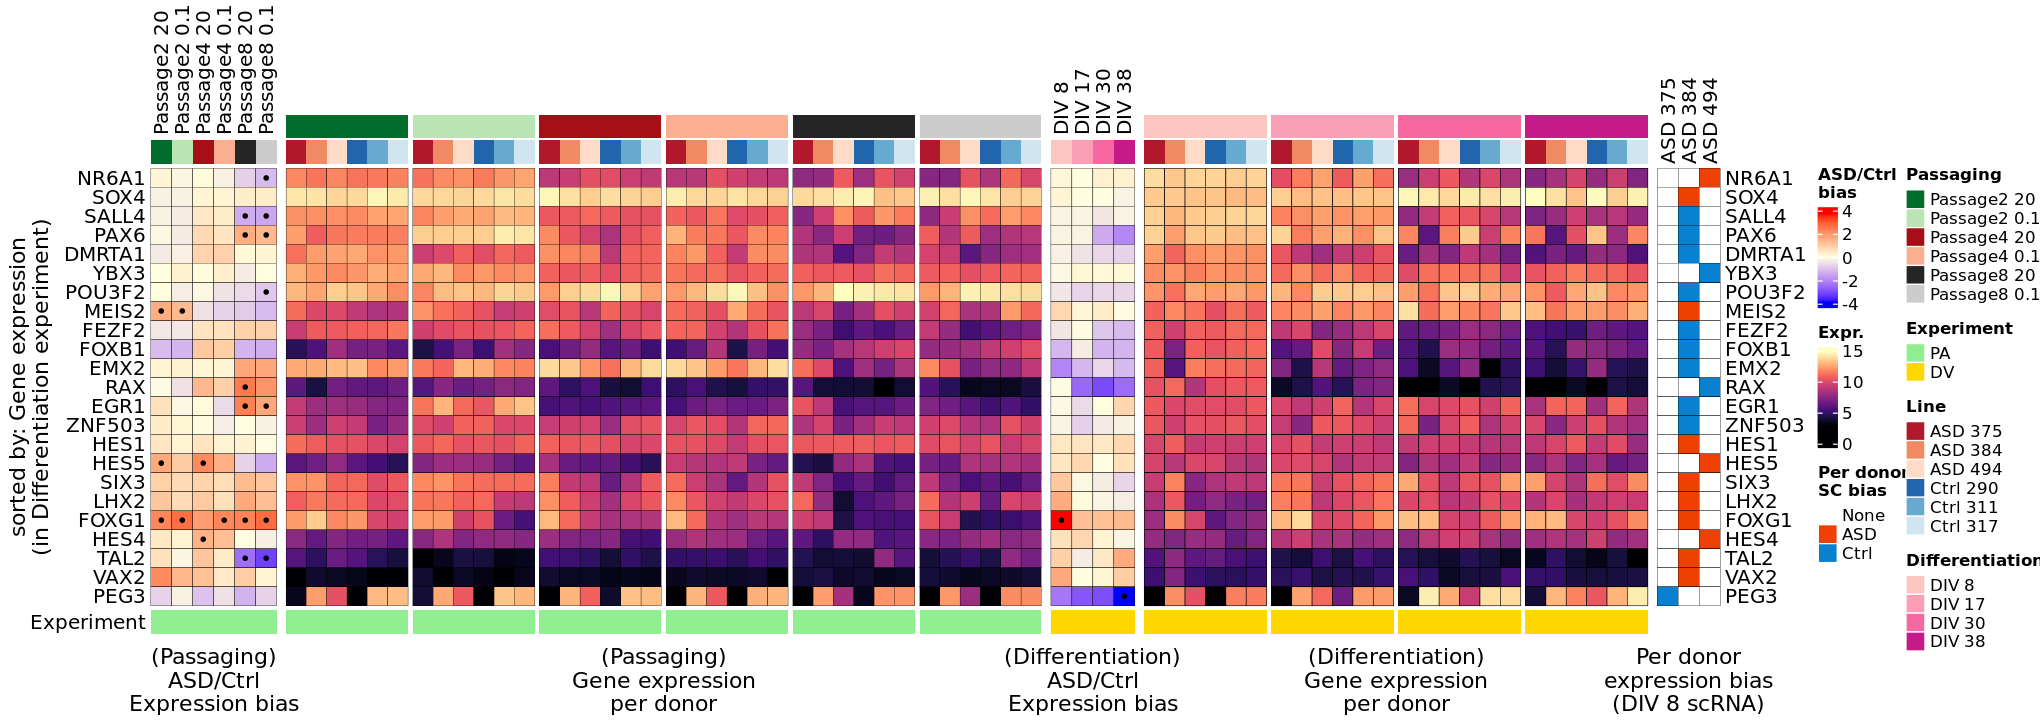

In [29]:
fig(w = 17,6)

lapply(names(orders), function(order.name){
    
    these.genes <- orders[[order.name]]
    
    mat <- mat[these.genes,]
    smat <- smat[these.genes,]
    pa.lfc <- pa.lfc[these.genes,]
    dv.lfc <- dv.lfc[these.genes,]
    pa.smat <- smat[these.genes,colnames(pa.lfc)]
    dv.smat <- smat[these.genes,colnames(dv.lfc)]
    pa.mat <- pa.mat[these.genes,]
    dv.mat <- dv.mat[these.genes,]
    confusion.matrix <- confusion.matrix[these.genes,]

    cell_fun_pa <- function(j, i, x, y, w, h, col) { # add text to each grid
        r = min(unit.c(w, h))*0.4
        if(pa.smat[i, j]!='') {
            grid.circle(x, y, r, gp = gpar(fill = "black", col = "black"))
        }

    }
    cell_fun_dv <- function(j, i, x, y, w, h, col) { # add text to each grid
        r = min(unit.c(w, h))*0.6
        if(dv.smat[i, j]!='') {
            grid.circle(x, y, r, gp = gpar(fill = "black", col = "black"))
        }

    }


    htmp.pa.lfc <- Heatmap(
        
        row_title=paste0('sorted by: ', order.name),
        
        matrix = pa.lfc, top_annotation = topa.pa, bottom_annotation = bottoma.pa, cell_fun = cell_fun_pa,
        column_title='(Passaging)\nASD/Ctrl\nExpression bias', column_title_side = 'bottom',
        name='ASD/Ctrl -', show_heatmap_legend = F, col = col, 
        column_labels=pa.mat.meta$Passaging,
        rect_gp = gpar(col = "black", lwd = .3),
        cluster_rows = F, cluster_columns = F, cluster_row_slices = F,    cluster_column_slices = F,
        row_names_side = 'left', show_row_names = T,  show_column_names = T, column_names_side = 'top',
        use_raster=T)

    htmp.dv.lfc <- Heatmap(
        matrix = dv.lfc, top_annotation = topa.dv, bottom_annotation = bottoma.dv, cell_fun = cell_fun_dv,
        column_title='(Differentiation)\nASD/Ctrl\nExpression bias',column_title_side = 'bottom',
        name='ASD/Ctrl\nbias', col = col,
        column_labels=dv.mat.meta$Differentiation,
        rect_gp = gpar(col = "black", lwd = .3),
        cluster_rows = F, cluster_columns = F, cluster_row_slices = F,    cluster_column_slices = F,
        row_names_side = 'left', show_row_names = T,  show_column_names = T, column_names_side = 'top',
        use_raster=T)

    pa.exp.htmp <- Heatmap(pa.mat, top_annotation = topb.pa, bottom_annotation = bottomb.pa,
                           column_split = pa.meta$Passaging,
                           column_title='(Passaging)\nGene expression\nper donor',column_title_side = 'bottom',
                           col=magma(300),#c('lightyellow', 'skyblue4'),
                           show_heatmap_legend = F,
                           rect_gp = gpar(col = "black", lwd = .3),
                           cluster_rows=F, cluster_columns=F,cluster_row_slices=F, 
                           show_column_names=F, show_row_names = T, name='Expression - ')

    dv.exp.htmp <- Heatmap(dv.mat, top_annotation = topb.dv, bottom_annotation = bottomb.dv, 
                           column_split = dv.meta$Differentiation,
                           column_title='(Differentiation)\nGene expression\nper donor',column_title_side = 'bottom',
                           col=magma(300), show_heatmap_legend = T,
                           rect_gp = gpar(col = "black", lwd = .5),
                           cluster_rows=F, cluster_columns=F, cluster_row_slices=F,
                           show_column_names=F, show_row_names = F, name='Expr.')


    conf.htmp <- Heatmap(confusion.matrix, name='Per donor\nSC bias',
                         column_labels = colnames(confusion.matrix)%>%
                             gsub(pattern='_',replacement=' ')%>%gsub(pattern='D8 ',replacement=''),
                         column_title='Per donor\nexpression bias\n(DIV 8 scRNA)',
                         column_names_side = 'top',column_title_side = 'bottom',
                         rect_gp = gpar(col = "black", lwd = .3),
                         col=setNames(c('white', 'orangered2', '#0981D1', 'purple'),c('None', 'ASD', 'Ctrl', 'ASD Ctrl')))
    
    draw(htmp.pa.lfc + 
    pa.exp.htmp +
    htmp.dv.lfc+
    dv.exp.htmp +
    conf.htmp)
    
}) -> htmp.ordereds

In [30]:
cairo_pdf(glue::glue('{today_dir}Overview.pdf'),width=17, height=6, onefile = T)
for(htmp in htmp.ordereds){
    grid.newpage()
    draw(htmp)
}

dev.off()


png 
  2

In [31]:
cairo_pdf(glue::glue('{today_dir}Selected.pdf'),width=17, height=6, onefile = T)
for(htmp in htmp.ordereds[1]){
    grid.newpage()
    draw(htmp)
}

dev.off()


png 
  2

### Scatter

In [32]:
library(ggplot2)
library(ggh4x)
library(ggpubr)

In [33]:
scatter.meta <- bulk.meta[sorted.samples,] %>% 
    mutate_at(vars(experiment, ExpStep, FGF, Line, Condition, test.name),
        function(x){if(is.numeric(x)){as.character(x)}else{x}}) %>% 
    mutate(Step=ExpStep, Experiment=experiment,ExpStep=NULL,experiment=NULL ) %>% 
    mutate(Step=ifelse(Experiment=='PA', paste(as.character(Step), FGF), as.character(Step)), 
           Step=factor(Step, levels=unique(Step)),
           # FGF=NULL, 
           Line=gsub(x=Line, pattern='434', replacement='494'),
           Line=factor(lines[Line], lines)) %>% 
    mutate(
        Experiment = factor(Experiment, levels=c('PA', 'DV'), labels=c('Passaging', 'Differentiation')),
        Passage2 = gsub(Passage2, pattern='Passage', replacement='Passage ') %>% factor(., levels=unique(.)),
        FGF2 = factor(ifelse(is.na(FGF), '', paste(FGF, 'FGF')), levels=c('20 FGF','0.1 FGF', '')))

In [34]:
plot_one_gene <- function(G, exp.scatter, exp.units, with_lines=T){
        
    min.max <- range(subset(exp.scatter, Gene==G)$value)
    min.max[1] <- min.max[1]-.1*(min.max[2]-min.max[1])
    plot.bottom <- min.max[1]
    # print(G)
    # print(plot.bottom)

    ggplot(subset(exp.scatter, Gene==G), 
           aes(y=value,
           # x=Line, color=Condition, shape=Line)) + 
           # x=Line, fill=Line, shape=Line)) -> p 
           x=Condition, fill=Line, shape=Line)) -> p 

    if (with_lines){
        p <- p + geom_linerange(aes(ymin=max(plot.bottom, ybottom), ymax=value, color=Condition),
                               # color='#000000AA',
                               linewidth=.5, linetype=2) + 
            scale_color_manual(values=meta.cols$Condition)
    }

    p <- p + geom_point(size=4,stroke=1) + 

        scale_fill_manual(values=paste0(meta.cols$Line, 'AA')) + 
        scale_shape_manual(values=c(23:25, 23:25)) + 

        facet_nested(nest_line = T, solo_line = F, 
                     rows=vars(glue::glue('Gene expression ({exp.units})')), 
                     cols=vars(Experiment, Passage2, FGF2),
                     switch='y') -> p

        p <- p + theme_bw() + labs_pubr() + theme(panel.grid.major.x = element_blank())
        p <- p + theme(strip.placement = 'outside', strip.background = element_rect(fill='#00000022', color='transparent'))

        p <- p + labs(y=NULL, x=paste0('Expression per line (', exp.units, ')')) + ggtitle(paste0(G, ': Passaging & Differentiation bulk experiments'))

#         p <- p + scale_x_discrete(labels=function(x){sapply(strsplit(x, split=' ', fixed=T),
#                                                             function(y){y[1]})%>%ifelse(test = c(F,T,F,F,T,F), no='')})

        if (exp.units=='log10 counts'){
            p <- p + scale_y_log10(limits = min.max, expand=expansion(mult=c(0,0.1)))
        } else {
            p <- p + scale_y_continuous(limits = min.max, expand=expansion(mult=c(0,0.1)))
        }

    return(p)
}

In [35]:
fig(17,5)
    
exp.genes <- rge.ind.marker.genes
# expression, from DESeq2::vst

In [36]:
# for (exp.units in c('log_counts', 'tpm', 'scaled_tpm', 'vst')){
for (exp.units in c('vst')){
    
    ybottom <- 0
    if (exp.units == 'log_counts'){
        exp.units <- 'log10 counts'
        pa.exp.scatter <- bulk.seurats$PA[['RNA']]@counts[exp.genes,rownames(pa.meta)] + 1
        dv.exp.scatter <- bulk.seurats$DV[['RNA']]@counts[exp.genes,rownames(dv.meta)] + 1
        ybottom <- 1
    }else if (exp.units == 'tpm'){
        exp.units <- 'TPM'
        pa.exp.scatter <- bulk.seurats$PA[['RNA']]@data[exp.genes,rownames(pa.meta)]
        dv.exp.scatter <- bulk.seurats$DV[['RNA']]@data[exp.genes,rownames(dv.meta)]
    }else if (exp.units == 'scaled_tpm'){
        exp.units <- 'scaled TPM'
        pa.exp.scatter <- bulk.seurats$PA[['RNA']]@scale.data[exp.genes,rownames(pa.meta)]
        dv.exp.scatter <- bulk.seurats$DV[['RNA']]@scale.data[exp.genes,rownames(dv.meta)]
    }else if (exp.units == 'vst'){
        exp.units <- 'VST'

        # expression, from DESeq2::vst
        pa.exp.scatter <- assay(pa.rld)[sapply(exp.genes, function(x){grepl(pattern=x, x=rownames(pa.rld))})%>%rowSums()%>%as.logical,]
        rownames(pa.exp.scatter) <- strsplit(rownames(pa.exp.scatter), split='|', fixed=T) %>% sapply(function(x){x[2]}) %>% make.unique()
        pa.exp.scatter <- pa.exp.scatter[exp.genes, rownames(pa.meta)]

        dv.exp.scatter <- assay(dv.rld)[sapply(exp.genes, function(x){grepl(pattern=x, x=rownames(dv.rld))})%>%rowSums()%>%as.logical,]
        rownames(dv.exp.scatter) <- strsplit(rownames(dv.exp.scatter), split='|', fixed=T) %>% sapply(function(x){x[2]}) %>% make.unique()
        dv.exp.scatter <- dv.exp.scatter[exp.genes, rownames(dv.meta)] 
    }

    exp.scatter <- cbind(pa.exp.scatter, dv.exp.scatter) %>% as.matrix()
    exp.scatter <- reshape2::melt(exp.scatter) %>%dplyr::rename(Gene=Var1, Sample=Var2)%>% 
        merge(y=scatter.meta, by.x='Sample', by.y='row.names') %>% as.data.frame()
    # stop()
    lapply(exp.genes, function(G){
        plot_one_gene(G, exp.scatter, exp.units, with_lines=F)
    }) -> ps

    
    cairo_pdf(glue::glue('{today_dir}Bulk_expression_per_line.{exp.units}.pdf'),
              width=17, height=5, onefile = T)
    for(p in ps){
        plot(p)
    }

    dev.off()
    
    # break
    }

In [37]:
# expression, from DESeq2::vst

# for (exp.units in c('log_counts', 'tpm', 'scaled_tpm', 'vst')){
for (exp.units in c('vst')){
    
    ybottom <- 0
    if (exp.units == 'log_counts'){
        exp.units <- 'log10 counts'
        pa.exp.scatter <- bulk.seurats$PA[['RNA']]@counts[exp.genes,rownames(pa.meta)] + 1
        dv.exp.scatter <- bulk.seurats$DV[['RNA']]@counts[exp.genes,rownames(dv.meta)] + 1
        ybottom <- 1
    }else if (exp.units == 'tpm'){
        exp.units <- 'TPM'
        pa.exp.scatter <- bulk.seurats$PA[['RNA']]@data[exp.genes,rownames(pa.meta)]
        dv.exp.scatter <- bulk.seurats$DV[['RNA']]@data[exp.genes,rownames(dv.meta)]
    }else if (exp.units == 'scaled_tpm'){
        exp.units <- 'scaled TPM'
        pa.exp.scatter <- bulk.seurats$PA[['RNA']]@scale.data[exp.genes,rownames(pa.meta)]
        dv.exp.scatter <- bulk.seurats$DV[['RNA']]@scale.data[exp.genes,rownames(dv.meta)]
    }else if (exp.units == 'vst'){
        exp.units <- 'VST'

        # expression, from DESeq2::vst
        pa.exp.scatter <- assay(pa.rld)[sapply(exp.genes, function(x){grepl(pattern=x, x=rownames(pa.rld))})%>%rowSums()%>%as.logical,]
        rownames(pa.exp.scatter) <- strsplit(rownames(pa.exp.scatter), split='|', fixed=T) %>% sapply(function(x){x[2]}) %>% make.unique()
        pa.exp.scatter <- pa.exp.scatter[exp.genes, rownames(pa.meta)]

        dv.exp.scatter <- assay(dv.rld)[sapply(exp.genes, function(x){grepl(pattern=x, x=rownames(dv.rld))})%>%rowSums()%>%as.logical,]
        rownames(dv.exp.scatter) <- strsplit(rownames(dv.exp.scatter), split='|', fixed=T) %>% sapply(function(x){x[2]}) %>% make.unique()
        dv.exp.scatter <- dv.exp.scatter[exp.genes, rownames(dv.meta)] 
    }

    
    exp.scatter <- cbind(pa.exp.scatter, dv.exp.scatter) %>% as.matrix()
    exp.scatter <- reshape2::melt(exp.scatter) %>%dplyr::rename(Gene=Var1, Sample=Var2)%>% 
        merge(y=scatter.meta, by.x='Sample', by.y='row.names') %>% as.data.frame()
    
    
    split(exp.scatter, exp.scatter$Step) -> exp.steps.scatter
    
    lapply(names(exp.steps.scatter), function(step){
        
        lapply(exp.genes, function(G){
            plot_one_gene(G, exp.scatter=exp.steps.scatter[[step]], exp.units, with_lines=F) + ggtitle(glue::glue('{G}\n{step}'))
        }) -> ps
    }) %>%setNames(nm=names(exp.steps.scatter)) -> exp.step.plots


    for (step in names(exp.step.plots)){
        
        message(glue::glue('Saving {step}'))
        
        cairo_pdf(glue::glue('{today_dir}Bulk_expression_per_line.{exp.units}.{step}.pdf'),
                  width=4, height=5, onefile = T)
        for(p in exp.step.plots[[step]]){ plot(p) }
        dev.off()
    }
    break
}

Saving Passage2 20

Saving Passage2 0.1

Saving Passage4 20

Saving Passage4 0.1

Saving Passage8 20

Saving Passage8 0.1

Saving DIV 8

Saving DIV 17

Saving DIV 30

Saving DIV 38



### Clusters

In [151]:
k <- 4

library(amap)
gene_clusters <- Kmeans(x = cbind(pa.mat, dv.mat)[,sorted_samples], centers=k, method="pearson", iter.max=100)$cluster

gene.clus <- gene_clusters
sapply(split(names(gene.clus), gene.clus), function(gs){
    mean(mat[gs,])
}) %>% sort %>% names %>% rev -> cl.order
cl.labels <- LETTERS[1:length(unique(cl.order))]

gene.clus <- setNames(factor(as.character(gene.clus), levels=cl.order, labels=LETTERS[1:length(unique(gene.clus))]), names(gene.clus))
grow <- 6
gcol <- 4

cl.annot <- sapply(split(names(gene.clus), gene.clus), function(gs){
    gss <- rowSums(mat[gs,, drop=F])%>% sort%>% rev %>% head(gcol*grow)
    gss <- c(gss, rep('', gcol*grow))[1:(gcol*grow)]
    gss <- matrix(names(gss), ncol = gcol, byrow = T) %>% apply(MARGIN=1, function(x){paste0(x[x!=''], collapse=',')})#%>% paste0(`.`[.!=''], collapse='\n')
    gss <- paste(gss[gss!=''], collapse='\n')
    gss
}) 

In [36]:
# exp.type <- 'raw'

# if (exp.type=='tpm'){
#     bulk.exp <- bulk.tpm
# } else {
#     bulk.exp <- bulk.raw
#     bulk.exp[,-1] <- log2(bulk.exp[,-1]+1)
# }

# bulk.genemeta$cluster <- NA

# bulk.genemeta$cluster <- ifelse(
#     bulk.genemeta$GeneName%in%names(gene.clus),
#     plyr::mapvalues(
#         x=bulk.genemeta$GeneName, 
#         from=names(gene.clus),
#         to=as.character(gene.clus)),
#     bulk.genemeta$cluster) %>% factor(levels=cl.labels)

# subset(bulk.genemeta, !is.na(cluster) )%>% 
#     select(GeneID, GeneName, cluster) %>%
#     merge(y = reshape2::melt(bulk.exp, id.vars='GENE', variable.name='sample'), value.name='expression', by.x='GeneID',by.y='GENE', all.x=T, all.y=F) %>%
#     merge(y = bulk.meta%>% mutate(sample=rownames(bulk.meta)), by='sample', all.x=T, all.y=F) -> exp.annot.long

# library(ggplot2)
# library(ggh4x)
# library(ggpubr)

# exp.annot.long <- exp.annot.long %>% mutate(
#     Experiment=factor(as.character(experiment), levels=c('PA', 'DV')),
#     `FGF2 Dose` = ifelse(is.na(FGF), '', as.character(FGF)),
#     gene.line.group = paste(GeneID, Line))    

# p <- ggplot(exp.annot.long, 
#                 aes(x = ExpStep,
#                     y=value, 
#                     color = Condition,  
#                     linetype=Condition, 
#                     fill = Condition)) + 
#     geom_line(aes(group =gene.line.group), alpha=0.1, linewidth=0.1) +
#     # geom_boxplot() +
#     geom_smooth(aes(group =Condition)) +
#     scale_color_manual(values=c('ASD'='darkred', 'Ctrl'='darkblue')) +
#     scale_fill_manual(values=c('ASD'='tomato', 'Ctrl'='cadetblue2')) +
#     facet_nested(rows=vars(cluster), 
#                  cols=vars(Experiment, `FGF2 Dose`), 
#                  scales='free', independent='x', switch='y', nest_line=T) +
#     # guides(linetype=guide_none()) +
#     labs(y=NULL, x='Experimental step') +
#     # theme_minimal() +
#     theme_pubr() + 
#     theme_minimal() +
#     theme(strip.text.y.left = element_text(angle=0, vjust=1, hjust=1),
#         strip.placement = 'outside',
#         axis.line.x.top = element_line(size=.3),
#         axis.line.x.bottom = element_line(size=.3),
#         axis.line.y.left = element_line(size=.3),
#         axis.line.y.right = element_line(size=.3),
#         plot.margin = unit(c(1,1,0,0), "cm"), legend.position='top') +
#     ggtitle('Expression of DE TFs accross timepoints and FGF2 conditions\nin bulk experiments',
#             subtitle=glue::glue('Expression: TPM\nGenes grouped in {k} expression patterns'))

# topnames <- data.frame(annot=cl.annot, cl = names(cl.annot), Experiment=NA, FGF=NA) %>% ggplot() + 
#     geom_text( 
#               mapping=aes(x=0,y=0, label=annot),
#               vjust=1, hjust=0,
#               size=3)+ 
#     theme_pubr() + 
#     theme(axis.line = element_blank(), strip.text = element_blank(),
#           axis.ticks = element_blank(), axis.text = element_blank()) + 
#     scale_x_continuous(limits=c(0,1))+
#     scale_y_continuous(limits=c(-1,0)) + 
#     theme(plot.margin = unit(c(0,0,0,0), "cm"), 
#           axis.line.y.left = element_line(size=.4)) +
#     facet_nested(rows=vars(cl), cols=vars(Experiment, FGF), nest_line = T, independent='x', scales='free') +
#     labs(x=NULL, y=NULL)

# suppressMessages(expr={suppressWarnings(expr = {
#     combined.p <- cowplot::plot_grid(p, topnames, align='h', axis='tb', nrow=1, rel_widths = c(5,1.4))
# })})
# combined.p

# fig(15,13)
# combined.phtmp <- cowplot::plot_grid( grid.grabExpr(expr = {draw(htmp, merge_legend = TRUE)}), combined.p, rel_widths = c(3,7))
# plot(combined.phtmp)

# cairo_pdf(glue::glue('{today_dir}fig_5_e.k_{k}.data_{exp.type}.pdf'),width=10, height=12, onefile = T)
# draw(htmp, merge_legend = TRUE)
# plot(combined.p)
# dev.off()

# cairo_pdf(glue::glue('{today_dir}fig_5_e_combined.k_{k}.data_{exp.type}.pdf'),width=15, height=13, onefile = T)
# plot(combined.phtmp)
# dev.off()

# Functions

## ComplexHeatmap of a seurat object

In [ ]:
do.Heatmap <- function(
    obj, genes,
    # core=NULL,
    gene.split.var = NULL,
    annot.sample.vars = NULL,
    annot.sample.colors = NULL,
    
    row.name.size = 12,
    
    group.sample.vars=NULL,
    split.sample.vars=NULL,
    
    exp.slot='scale.data',
    exp.col = NULL,
    exp.name=NULL,
    disp.min=NULL, disp.max=NULL,
    
    cluster_rows = T,
    cluster_columns = F,

    annot.gene.means = T,
    gene.means.exp.slot = 'data',
    
    add.FC.heatmap = T,
    FC.table = FC_table,
    FC.column.var=NULL,
    
    use_raster = T,
    
    rm.zero.counts.genes = T,
    
    label.prefix=NULL, 
    
    min.counts = 3,...
    
){
    
    # Function to label text
    label.with.prefix <- function(lab, prefix=label.prefix, sep=' '){
        if(is.null(prefix)){
            return(lab)
        }else{
            paste(prefix, lab, sep=sep)
        }
    }

    # Minimum display value (all values below are clipped)
    if (is.null(disp.min)){
        disp.min <- if(exp.slot=='scale.data'){-2.5}else{0}
    }
    if (is.null(disp.max)){
        # Maximum display value (all values above are clipped); defaults to 2.5 if slot is 'scale.data', 6 otherwise
        disp.max <- if(exp.slot=='scale.data'){2.5}else{6}
    }
    if (is.null(exp.col)){
        if (exp.slot=='scale.data'){
            # exp.col <- colorRamp2(c(disp.min, 0, disp.max), c("blue", "lightyellow", "tomato"))
            exp.col <- colorRamp2(c(disp.min, 0, disp.max), c('#0D0887','#CC4678','#F0F921'))
        } else {
            exp.col <- colorRamp2(c(disp.min, disp.max), c("lightyellow", "tomato"))
        }
    }
    
    if (rm.zero.counts.genes){
        zero.counts <- FetchData(obj, vars = genes, slot = 'counts') %>% colSums()
        present <- names(zero.counts)
        zero.counts <- names(zero.counts)[zero.counts<min.counts]
        message(paste0('Found ', length(zero.counts), ' zero-expression genes (provided: ', length(genes), '; in exp: ', length(present),')'))
        
        valid.genes <- genes[(genes%in%present)&!(genes%in%zero.counts)]
    } else {
        valid.genes <- genes
    }
    
    if (length(group.sample.vars) > 0){
        # Find groups
        groups <- unique(obj@meta.data[unique(c(group.sample.vars, annot.sample.vars))])
        groups <- groups %>% mutate(label=apply(groups[group.sample.vars], 1, paste, collapse='_'))
        rownames(groups) <- groups$label

        if (length(valid.genes)==1){
            print('Extra gene-trick for grouped expression')
            extra.gene <- rownames(obj)[!rownames(obj)%in%valid.genes][1]
            avg.obj <- AverageExpression(obj, features = c(valid.genes, extra.gene), group.by = group.sample.vars, return.seurat = T, min.cells=0, min.features=0)
            avg.obj <- avg.obj[rownames(avg.obj)%in% valid.genes,]
        } else {
            avg.obj <- AverageExpression(obj, features = valid.genes, group.by = group.sample.vars, return.seurat = T, min.cells=0, min.features=0)
        }

        avg.obj@meta.data <- cbind(avg.obj@meta.data, groups[rownames(avg.obj@meta.data),])
        exp.obj <- avg.obj 

    } else {
        exp.obj <- obj
    }

    if (length(annot.sample.vars) > 0){
        annot.sample.data <- FetchData(exp.obj, vars = annot.sample.vars)
        annot.sample.row <- HeatmapAnnotation(df = annot.sample.data,
                                              annotation_name_side = 'left',
                                              col = annot.sample.colors)
    } else {
        annot.sample.row <- NULL
    }

    if (length(split.sample.vars) > 0){
        split.sample.data <- FetchData(exp.obj, vars = split.sample.vars)
        group.split <- factor(apply(split.sample.data, 1, c))
    } else {
        group.split <- NULL
    }
    
    
    # print('exp.data')
    exp.data <- FetchData(exp.obj, vars = valid.genes, slot = exp.slot)
    exp.data[exp.data<disp.min] <- disp.min
    exp.data[exp.data>disp.max] <- disp.max

    
    valid.genes <- valid.genes[valid.genes%in%colnames(exp.data)]
    
    if (length(valid.genes) == 0 ){
        
        message('No valid genes provided')
        print(head(exp.data))
    }
    
    if (length(valid.genes) == 1 ){
        
        message('One-gene plot')

    }
    
#     if((5*length(valid.genes)) > 150){
#         row.height <- 150/length(valid.genes)
#     } else {
#     }
#     row.height <- 0.2
    font.size <- grid::gpar(fontsize = unit(row.name.size, 'mm'))
    # } else {
    #     font.size <- NULL
    # }


    exp.data <- t(exp.data)


    # To do: receive from seurat
    if (!is.null(gene.split.var)){
        
        if (length(gene.split.var)==1){
            gene.split <- as.factor(seu[['RNA']]@meta.features[valid.genes,gene.split.var])
        } else {
            gene.split <- gene.split.var
        }
    } else {
        gene.split <- NULL
    }

    if (is.null(exp.name)){
        exp.name <- c('scale.data'='ScaledExp', 'data'='LogNormExp', 'counts'='RawExp')[exp.slot]
        exp.name <- label.with.prefix(exp.name)
    } 
    
    
    htmp <- Heatmap(exp.name,

                    show_parent_dend_line = F,

                    matrix = exp.data,
                    col = exp.col,
                    # height = unit(5, "mm")*length(valid.genes),
                    width = 41,

                    cluster_rows = cluster_rows, 
                    cluster_columns = cluster_columns, 
                    cluster_row_slices = F,
                    cluster_column_slices = F,
                    row_names_side = 'left',
                    show_row_names = T, 
                    row_names_gp = font.size,
                    row_split = gene.split,
                    column_split = group.split,
                    show_column_names = F, 

                    top_annotation = annot.sample.row,
                    
                    
                    use_raster=T

                    # right_annotation = mean_column
                    )
    full.heatmap <- htmp

    if (annot.gene.means){
        
        mean.exp.name <- label.with.prefix('MeanExp')
        annot.gene.data <- data.frame(FetchData(exp.obj, vars = valid.genes, slot = gene.means.exp.slot) %>% colMeans())
        colnames(annot.gene.data) <- mean.exp.name
        annot.gene.mean.column <- Heatmap(name = mean.exp.name,
                                          show_row_names = T,
                                          matrix = annot.gene.data, 
                                          width=1,
                                          col=if (length(valid.genes) == 1) {NULL} else {RColorBrewer::brewer.pal(n=9,  name = 'Blues')})

        full.heatmap <- full.heatmap + annot.gene.mean.column
    } 


    if (add.FC.heatmap){
        FC.data <- FC.table[valid.genes,]
        FC.data[is.na(FC.data)] <- 0
        rownames(FC.data) <- valid.genes
        
        if (!is.null(FC.column.var)){
            annot.cluster.fc <- data.frame(colnames(FC.data))
            colnames(annot.cluster.fc)[1] <- FC.column.var
            annot.cluster.fc <- HeatmapAnnotation(df = annot.cluster.fc,
                                                  show_legend = F,
                                                  show_annotation_name = F,
                                                  col = annot.sample.colors)
        } else {
            annot.cluster.fc <- NULL
        }


        FC.rng <- max(abs(FC.data))
        FC.rng <- c(-FC.rng,0,FC.rng)
        # FC.color <- colorRamp2(FC.rng, c("brown", "white", "forestgreen"))
        FC.color <- colorRamp2(FC.rng, c("darkblue", "white", "darkred"))
        
        fc.htmp <- Heatmap(name = 'ASD/Ctrl\nExpFC', 
                           matrix = FC.data,
                           col = FC.color,
                           # row_names_gp = font.size,
                           row_names_gp = font.size,
                           cluster_columns = F, 
                           width=7,
                           top_annotation = annot.cluster.fc)

        full.heatmap <- full.heatmap + fc.htmp

    }

    return(full.heatmap)
    
}

# Parameters

In [ ]:
# To show grouped cells, not every cell
group.sample.vars <- c('anno_cluster_fct', 'cell_origin')
# To color on top of heatmap
annot.sample.vars <- c('anno_cluster_fct', 'cell_origin', 'origin_sex')
# To choose colors to show
annot.sample.colors <- list('cell_origin'=samples.colors, 
                            'anno_cluster_fct'=cell.type.colors,
                            'origin_sex'=origin_sex.colors)


# Figures

In [ ]:
fres <- subset(sc.dea.df, filter.2of3.over.2of3  & (p_val_adj < 0.05) & gene.is.tf)

fres <- fres %>% group_by(gene) %>% reframe(g=paste(sort(unique(overexpressed.in.)), collapse=','))
fres

In [ ]:
genes1 <- fres$gene
genes1.cat <- factor(fres$g, c('Ctrl', 'ASD', 'ASD,Ctrl'))

## Panel E  
- logFC of ASD-Ctrl in bulk experiments
- clustered together
- with stars for significant logFCs

In [ ]:
exp.join <- cbind(
    bulk.seurats$PA[['RNA']]@scale.data,
    bulk.seurats$DV[['RNA']]@scale.data)
meta.join <- rbind(
    bulk.seurats$PA@meta.data,
    bulk.seurats$DV@meta.data)

smat <- bulk.sig.table[genes1,]
smat <- smat[apply(smat != '',1, any),]
pmat <- bulk.fc.table[rownames(smat),]

# pmat
# smat

cell_fun <- function(j, i, x, y, w, h, col) { # add text to each grid
    grid.text(smat[i, j], x, y)
}

range(pmat)

fig(7,15)
Heatmap(
    cell_fun = cell_fun,
    col = circlize::colorRamp2(colors=c('blue', 'white', 'red'), breaks = c(-7,0,17)),
    pmat, cluster_columns = F, column_split = c(rep('DIV',4), rep('PA',6)),
    # row_split = genes1.cat[genes1%in%rownames(pmat)]
)

### All genes

#### Test

In [ ]:
htmp <- do.Heatmap( 
    obj=seu,
    genes=genes1,

    annot.sample.vars = annot.sample.vars,
    annot.sample.colors = annot.sample.colors,

    group.sample.vars = group.sample.vars,
    split.sample.vars = c('anno_cluster_fct'),

    exp.slot='scale.data',
    # exp.col = viridis(300, option='cividis', direction=1),

    cluster_rows = T,
    cluster_columns = F,

    annot.gene.means = T,

    add.FC.heatmap = T,
    FC.table = sc.fc.table,
    FC.column.var='anno_cluster_fct'
)

fig(15,10)
htmp

In [ ]:
dev.off()

In [ ]:
pdf('./Heatmap.av_genes.SC_FC.pdf', width=12, height=6)
plot(htmp)
dev.off()

#### All regulons

# Add bulk to heatmap

In [ ]:
first(annot.sample.colors$cell_origin)

In [ ]:
unique(bulk.seurats$DV$ExpStep)

In [ ]:
bulk.sample.colors <- list(
    'ExpStep' = c(
        setNames(
            RColorBrewer::brewer.pal(n = 4, name = 'PuBuGn')[-1],
            unique(bulk.seurats$PA$ExpStep)),
        setNames(
            RColorBrewer::brewer.pal(n = 4, name = 'PuOr'),
            unique(bulk.seurats$DV$ExpStep))),
    'FGF' = setNames(
        c('forestgreen', 'lightgreen'),
        unique(bulk.seurats$PA$FGF)),
    'Condition' = c('ASD'=first(annot.sample.colors$cell_origin),
                  'Ctrl'=unname(annot.sample.colors$cell_origin[4]))
)

In [ ]:
unique(bulk.seurats$PA$FGF)

### Plot a list of genes

In [ ]:
# rownames(htmp@ht_list$ScaledExp@matrix) ->  prev.htmp.genes
# TFDE_genes -> prev.htmp.genes
genes1 -> prev.htmp.genes

In [ ]:
pa.htmp <- do.Heatmap(rm.zero.counts.genes = F,
                      exp.name = 'Passaging',
                      obj=bulk.seurats$PA,
                      genes=prev.htmp.genes,
                      row.name.size=7,
                      gene.split.var = genes1.cat,
                      annot.sample.vars = c('ExpStep', 'FGF', 'Condition'),
                      annot.sample.colors = bulk.sample.colors,
                
                      # group.sample.vars = c('ExpStep', 'FGF', 'Condition'),
                      split.sample.vars = c('test.name'),

                      exp.slot='scale.data', disp.min=0, disp.max=1,
                      # exp.col = viridis(300, option='cividis', direction=1),
                      exp.col = colorRamp2(breaks = c(0,1), colors = c('lightyellow', 'tomato')),
                      # cluster_rows = T,
                      cluster_columns = F,

                      annot.gene.means = T,
                      label.prefix='BulkPA',

                      add.FC.heatmap = F,
                      # FC.table = FC_table
)

pa.fc.cols <- bulk.seurats$PA@meta.data$test.name %>% unique()

pa.fc.htmp <- Heatmap(name = 'PA log2FC', row_names_gp = grid::gpar(fontsize = unit(7, 'mm')),

                      matrix = bulk.fc.table[prev.htmp.genes,pa.fc.cols], cluster_columns = F)

In [ ]:
pa.full.htmp <- pa.htmp + pa.fc.htmp

In [ ]:
fig(10,15)
pa.full.htmp

In [ ]:
dv.htmp <- do.Heatmap(rm.zero.counts.genes = F,
                        exp.name = 'Differentiation',
                        obj=bulk.seurats$DV,
                        genes=prev.htmp.genes,
                      row.name.size=7,

                        annot.sample.vars = c('ExpStep', 'Condition'),
                        annot.sample.colors = bulk.sample.colors,

                        # group.sample.vars = c('Passage2', 'X20ng.ml.FGF2', 'Disease'),
                        split.sample.vars = c('ExpStep'),

                        exp.slot='scale.data', disp.min=0, disp.max=1,
                        # exp.col = viridis(300, option='cividis', direction=1),
                        exp.col = colorRamp2(breaks = c(0,1), colors = c('lightyellow', 'tomato')),
                        # cluster_rows = T,
                        cluster_columns = F,

                        annot.gene.means = T,
                        label.prefix='BulkDV',

                        add.FC.heatmap = F,
                        # FC.table = FC_table
)

dv.fc.cols <- bulk.seurats$DV@meta.data$test.name %>% unique()

dv.fc.htmp <- Heatmap(name = 'DV log2FC', row_split=
                      row_names_gp = grid::gpar(fontsize = unit(7, 'mm')),
                      matrix = bulk.fc.table[prev.htmp.genes,dv.fc.cols], cluster_columns = F)

dv.full.htmp <- dv.htmp + dv.fc.htmp

In [ ]:
fig(6,8)
pa.fc.htmp + dv.fc.htmp

In [ ]:
pdf('./Heatmap.detf_genes.PAFC_DVFC.pdf', width=4, height=7)
pa.fc.htmp + dv.fc.htmp

dev.off()

In [ ]:
fig(20,10)

In [ ]:
pa.full.htmp + dv.full.htmp

In [ ]:
htmp + pa.full.htmp + dv.full.htmp

In [ ]:
htmp + bulk.fc.htmp

In [ ]:
genes <- rownames(htmp@ht_list[[1]]@matrix)

In [ ]:
exp.mat <- bulk.seurats$PA[['RNA']]@data[genes,]
rownames(exp.mat) <- genes
exp.mat[is.na(exp.mat)] <- 0
exp.mat <- apply(exp.mat, 1, function(x){x/(max(c(x,1)))}) %>% t() %>% as.data.frame()

In [ ]:
fig(20,10)

In [ ]:
htmp + Heatmap(exp.mat, cluster_rows = T, cluster_columns = T)

# ASD/Ctrl DEGs

## Macaque

In [ ]:
macaque_regulon_table <- openxlsx::read.xlsx('../table S5 PAT_TFnetwork.xlsx', startRow = 2)

In [ ]:
get.macaque.regulon <- function(gene, upstream=T, downstream=T, other.edges=F, as.graph=F){
    regulon <- data.frame()
    up.genes <- c()
    down.genes <- c()
    
    if (upstream){
        up.reg <- subset(macaque_regulon_table, to == gene)
        up.genes <- unique(up.reg$from)
        regulon <- plyr::rbind.fill(regulon, up.reg)
    }
    if (downstream){
        down.reg <- subset(macaque_regulon_table, from == gene)
        down.genes <- unique(down.reg$to)
        regulon <- plyr::rbind.fill(regulon, down.reg)
    }
    if (other.edges){
        all.genes <- unique(c(up.genes, down.genes, gene, recursive = T))
        other.reg <- subset(macaque_regulon_table, (from %in% all.genes) & (to %in% all.genes))
        regulon <- plyr::rbind.fill(regulon, other.reg)
    }
    
    regulon <- unique(regulon)
    regulon <- regulon[,c(TRUE, TRUE, colSums(regulon[,-(1:2)]) != 0)]
    
    if (as.graph){
        g <- igraph::graph_from_data_frame(d = regulon, directed = T)
        return(g)
    } else {
        return(regulon)
    }
}

In [ ]:
g <- get.macaque.regulon(gene = 'FOXG1', as.graph=T, other.edges = T)

In [ ]:
regulon.df <- get.macaque.regulon(gene = 'FOXG1', as.graph=F, other.edges = T)

In [ ]:
plot(g, layout = get_fr_layout(g))

In [ ]:
macaque_regulon_sources <- unique(macaque_regulon_table$from)

In [ ]:
DE_genes[DE_genes %in% macaque_regulon_sources]

In [ ]:
source <- 'FOXG1'
reg.genes <- unique(c(unlist(regulon.df[,1:2]), recursive=T))

In [ ]:
seu <-Seurat::ScaleData(seu, features=reg.genes)

In [ ]:
cluster.order <- c('FGF17-like','RG early','RG late','Mes prog','Neral crest/Mes','Neuron','High-mito')
seu@meta.data$anno_cluster <-factor(seu@meta.data$anno_cluster, cluster.order)

In [ ]:
seu@meta.data$cell_origin <- factor(seu@meta.data$cell_origin, sort(unique(seu@meta.data$cell_origin)))

In [ ]:
avgexp <- Seurat::AverageExpression(seu, group.by = c('anno_cluster', 'cell_origin'), return.seurat = T)



In [ ]:
avgexp$anno_origin <- rownames(avgexp@meta.data)

In [ ]:
avgexp$anno_origin

In [ ]:
pdf('test.pdf', width=20, height=10)
Seurat::DoHeatmap(object = avgexp, features=reg.genes, slot='scale.data', group.colors = donor_color, raster = F, group.by = 'anno_origin')
dev.off()

In [ ]:
pdf('test.pdf', width=20, height=10)
Seurat::(object = seu, features=reg.genes, slot='scale.data', group.colors = donor_color_clusters, raster = F, group.by = 'anno_origin')
dev.off()

In [ ]:
plot.regulon.exp <- function(source, regulon.df, seu, include.source=T, combine.vars='ident', slot='scale.data', ...){
    reg.genes <- unique(c(unlist(regulon.df[,1:2]), recursive=T))
    
}

# cisTarget regulon

In [ ]:
cist_dis_regulon_table <- read.csv(file = '~/codebases/cortical_disorders2/results/RCT_diseases/cisTarget_regulons.csv')
cist_temp_regulon_table <- read.csv(file = '~/codebases/cortical_disorders2/results/RCT_peaks//cisTarget_regulons.csv')

In [ ]:
get.rct.regulon <- function(gene, rct.table='disease', upstream=T, downstream=T, other.edges=F, as.graph=F, rm.geneset = F){
    
    if (rct.table == 'disease'){
        regulons_table <- cist_dis_regulon_table
    } else if (rct.table == 'temporal'){
        regulons_table <- cist_temp_regulon_table
    }
    
    regulon <- data.frame()
    up.genes <- c()
    down.genes <- c()
    
    if (upstream){
        up.reg <- subset(regulons_table, Target == gene)
        up.genes <- unique(up.reg$Core)
        regulon <- plyr::rbind.fill(regulon, up.reg)
    }
    if (downstream){
        down.reg <- subset(regulons_table, Core == gene)
        down.genes <- unique(down.reg$Target)
        regulon <- plyr::rbind.fill(regulon, down.reg)
    }
    if (other.edges){
        all.genes <- unique(c(up.genes, down.genes, gene, recursive = T))
        other.reg <- subset(regulons_table, (Core %in% all.genes) & (Target %in% all.genes))
        regulon <- plyr::rbind.fill(regulon, other.reg)
    }
    
    if (rm.geneset){
        regulon <- regulon %>% mutate(geneSet = NULL, n.motifs = NULL, all.motifs = NULL)
    }
    
    regulon <- unique(regulon) %>% relocate(Core, Target) %>% arrange_all()

    
    if (as.graph){
        g <- igraph::graph_from_data_frame(d = regulon, directed = T)
        return(g)
    } else {
        return(regulon)
    }
}

In [ ]:
g <- get.rct.regulon(gene = 'FOXG1', rct.table='disease', as.graph=T, other.edges = T)
# g <- get.rct.regulon(gene = 'FOXG1', rct.table='temporal', as.graph=T, other.edges = T)
g

In [ ]:
plot(g, layout = get_fr_layout(g))

In [ ]:
DE_genes[DE_genes %in% V(g)$name]

seu# CellOracle's regulon

In [ ]:
co_dir <- '~/codebases/co_new/data_foxg1/'

In [ ]:
subsets <- list.files(co_dir)

In [ ]:
library(dplyr)

In [ ]:
grns <- list()
for (subs in subsets){
    message(subs)

    grn_files <- list.files(full.names = T, file.path(co_dir, subs, 'cluster_GRN')) %>% grep(pattern='raw', value=T, fixed=T)

    for (f in grn_files){
        ct <- ((strsplit(f, split='.raw', fixed=T)[[1]][1] %>% strsplit(split='/', fixed=T))[[1]] %>% rev())[1]
        grn <- data.table::fread(f) %>% mutate(V1=NULL)
        # grn <- subset(grn, ((source=='FOXG1') | (target == 'FOXG1')) & (p < 0.05))
        grn$cell.type <- ct
        grn$subset <- subs
        grns[[f]] <- grn
    }

}
grns <- as.data.frame(do.call('rbind', grns))
rownames(grns) <- NULL

In [ ]:
ct.factors <- c('vRG E', 'vRG L', 'tRG', 'oRG E', 'oRG L', 'nIPC', 'mGPC', 'Neu E', 'GluN1', 'GluN2', 'GluN3', 'GluN4', 'GluN5', 'GluN6', 'GluN7', 'GluN8', 'Astro', 'OPC')
grns$cell.type <- factor(grns$cell.type, ct.factors)

In [ ]:
grn.df <- grns[sample(1:nrow(grns), size=0.1*nrow(grns), replace=F), ]

In [ ]:
gene.to.color <- 'FOXG1'

### Histogram/Density/Vulcano of p-values/coefs

In [ ]:
library(ggplot2)
library(ggh4x)
library(ggpubr)

In [ ]:
fig(20,20)

In [ ]:
prepare.celloracle.color <- function(grn.df, 
                                     gene.to.color='FOXG1', 
                                     up.down.color.split=F, pos.neg.color.split = F){

    grn.df['color'] <- ''
    if (!is.null(gene.to.color)){
        
        if (up.down.color.split){
            grn.df['up.down'] <- plyr::mapvalues(
                x = paste(grn.df$source == gene.to.color, grn.df$target == gene.to.color),
                from = c('TRUE TRUE', 'TRUE FALSE', 'FALSE TRUE', 'FALSE FALSE'),
                to = c('Self-regulation', 'Genes targetted by it', 'Genes regulating it', ''))
            grn.df['color'] <- grn.df['up.down']
            
        } else {
            grn.df['color'] <- ifelse(
                ((grn.df$source == gene.to.color) | (grn.df$target == gene.to.color)),
                paste0(gene.to.color, ' link'), '')
        }
        
        if (pos.neg.color.split){
            grn.df['pos.neg'] <- ifelse(grn.df[,'coef_mean', drop=T] > 0, '(Pos.)', '(Neg.)')
            grn.df['color'] <- ifelse(grn.df[,'color', drop=T] == '', '',
                                      paste(grn.df[,'color', drop=T], grn.df[,'pos.neg', drop=T]))
        }
        
    }
    
    grn.df <- grn.df %>% arrange(color)
    return(grn.df)
}

In [ ]:
do.celloracle.histogram <- function(grn.df, 
                                    stat.plot='-logp',
                                    hist.or.dens = 'dens',
                                    overlay = T,
                                    
                                    gene.to.color='FOXG1', 
                                    up.down.color.split=F, pos.neg.color.split = F){
    
    
    grn.df <- prepare.celloracle.color(grn.df, gene.to.color=gene.to.color, 
                                       up.down.color.split=up.down.color.split, 
                                       pos.neg.color.split = pos.neg.color.split)
    
    
    p <- ggplot(
            grn.df %>% mutate(stat = grn.df[,stat.plot, drop=T]), 
            aes(x = stat, fill=color, color=color)) + 
    
        labs(x=stat.plot, color=gene.to.color, fill=gene.to.color) + 

        facet_nested(rows=vars(cell.type),  
                     cols=vars(subset), 
                     independent = 'y', scales='free', space='fixed')

    if (hist.or.dens == 'dens'){
        p <- p + geom_density(fill='transparent', position = "identity")
    } else {
        if (overlay){
            p <- p + geom_histogram(alpha = 0.5, position = "identity")
        } else {
            p <- p + geom_histogram(position = "stack")
        }
    }
    if(stat.plot=='-logp'){
        p <- p + geom_vline(xintercept = -log10(0.05))
        p <- p + geom_vline(xintercept = -log10(0.001))
    }else{
        p <- p + geom_vline(xintercept = 0)
    }
    
    p <- p + theme_pubr(base_family = 'ArialMT')
    
    return(p)
}

In [ ]:
do.celloracle.vulcano <- function(grn.df=grns,
                                  gene.to.color='FOXG1',
                                  up.down.color.split=F, 
                                  pos.neg.color.split = F){
    
    
    grn.df <- prepare.celloracle.color(grn.df, gene.to.color=gene.to.color, 
                                       up.down.color.split=up.down.color.split, 
                                       pos.neg.color.split = pos.neg.color.split)

    grn.df$color <- ifelse(grn.df$color == '', NA, grn.df$color)
    
    p <- ggplot(
        grn.df,
        aes(x = coef_mean, y=`-logp`, color=color, fill=color)) +

    labs(color=gene.to.color, fill=gene.to.color) + 

    facet_nested(rows=vars(cell.type),  
                 cols=vars(subset), 
                 independent = 'y',
                 scales='free', space='fixed') +
    
    geom_point(shape=16,alpha=0.5) +
    geom_vline(xintercept = 0) + geom_hline(yintercept=-log(0.05)) + 
    scale_fill_discrete(na.value = 'grey') + 
    scale_color_discrete(na.value = 'grey') +
    theme_pubr(base_family = 'ArialMT')

    return(p)
    
}

### Extract regulon

In [ ]:
get.co.regulon <- function(gene, regulons_table=grns, upstream=T, downstream=T, other.edges=F, as.graph=F, per.subset.per.celltype=F){

    if (!per.subset.per.celltype){
        regulon <- data.frame()
        up.genes <- c()
        down.genes <- c()

        if (upstream){
            up.reg <- subset(regulons_table, target == gene)
            up.genes <- unique(up.reg$source)
            regulon <- plyr::rbind.fill(regulon, up.reg)
        }
        if (downstream){
            down.reg <- subset(regulons_table, source == gene)
            down.genes <- unique(down.reg$target)
            regulon <- plyr::rbind.fill(regulon, down.reg)
        }
        if (other.edges){
            all.genes <- unique(c(up.genes, down.genes, gene, recursive = T))
            other.reg <- subset(regulons_table, (source %in% all.genes) & (target %in% all.genes))
            regulon <- plyr::rbind.fill(regulon, other.reg)
        }

        regulon <- unique(regulon) %>% relocate(source, target) %>% arrange_all()

        if (as.graph){
            g <- igraph::graph_from_data_frame(d = regulon, directed = T)
            return(g)
        } else {
            return(regulon)
        }
    } else {
        
        regulon.list <- list()
        
        for (subs in unique(regulons_table$subset)){
            
            # message(subs)

            for (ct in unique(regulons_table$cell.type)){
                
                # message(paste(subs, ct))
                
                sub.ct.grn <- subset(regulons_table, (subset == subs)&(cell.type==ct))
                sub.ct.regulon <- get.co.regulon(gene=gene, regulons_table=sub.ct.grn,
                                                 upstream=upstream, downstream=downstream, other.edges=other.edges, 
                                                 as.graph=F, per.subset.per.celltype=F)
                regulon.list[[paste(subs, ct)]] <- sub.ct.regulon
            }
        }
        
        regulon <- do.call('rbind', regulon.list) %>% as.data.frame() %>% relocate(source, target, subset, cell.type) %>% arrange_all()
        rownames(regulon) <- 1:nrow(regulon)
        
        if (as.graph){
            g <- igraph::graph_from_data_frame(d = regulon, directed = T)
            return(g)
        } else {
            return(regulon)
        }
    }
}

In [ ]:
regulon.df <- get.co.regulon(gene='FOXG1', regulons_table = grns, other.edges = T, per.subset.per.celltype = T, as.graph = F)

In [ ]:
g <- igraph::graph_from_data_frame(d = regulon.df, directed = T)
common.layout <- get_fr_layout(g)

# plot(g, layout = common.layout, vertex.size=2)


edge.mask <- (edge_attr(g, name = 'subset') == 'Gliogenesis') & (edge_attr(g, name = 'cell.type') == 'vRG E')

sub.g <- subgraph.edges(graph = g, eids = E(g)[edge.mask])
sub.layout <- common.layout[V(sub.g)$name,]

# plot(sub.g, layout = sub.layout, vertex.size=2)

In [ ]:
plot.co.reg.per.subset <- function(grn.df, common.layout=NULL, groupby='subset', v=T){
    
    # First, the LAYOUT
    if (is.null(common.layout)){
        common.layout <- get_fr_layout(graph_from_data_frame(grn.df, directed = T))
    }
    
    
    for (group in c('GENERAL_PLOT', unique(grn.df[, groupby, drop=T]))){
        
        if (v){message(group)}
        
        # Subset grn
        if (group != 'GENERAL_PLOT'){
            sub.grn <- grn.df[grn.df[groupby]==group,]
        } else {
            sub.grn <- grn.df
        }
        # Condense edges
        sub.grn <- sub.grn %>% group_by(source, target) %>% summarise_all(function(x){paste(as.character(x), collapse = ';')})
        
        # Convert to graph
        sub.g <- graph_from_data_frame(sub.grn, directed = T)
        
        # Retrieve layout
        sub.layout <- common.layout[V(sub.g)$name,]

        # Plot
        plot(sub.g, layout = sub.layout, vertex.size=3)
        mtext(group)
    }
        
    
    
}

In [ ]:
table(DE_genes%in%grns$source)

In [ ]:
DE_sources <- DE_genes[DE_genes%in%grns$source]
sort(DE_sources)

### AV GENES
- ONECUT2 is a gene expressed in neurons derived from RPC
- FOXG1  
- HES4
- HES5
- FEZF2  
### DORSAL/CAUDAL



In [ ]:
for (DEG in unique(c('FOXG1', DE_sources))){
    print(DEG)
    
    dens.1 <- do.celloracle.histogram(grns, stat.plot = '-logp', gene.to.color=DEG, 
                                      hist.or.dens = 'dens', overlay = T, 
                                      up.down.color.split=F, pos.neg.color.split=F) + 
        ggtitle(DEG, subtitle=paste('Distribution of p-values of all genes compared to', DEG))
    
    vulc.1 <- do.celloracle.vulcano(grns, gene.to.color=DEG, 
                                    up.down.color.split=F, pos.neg.color.split=F) + 
        ggtitle(DEG, subtitle=paste('Vulcano of p-values and coefficient of all genes compared to', DEG))
    
    pdf(paste0('DEG_plots/', DEG, '.ComparedToAll.pdf'), height=27, width=21)
    plot(dens.1)
    plot(vulc.1)
    dev.off()
    
    # # This regulon contains extra edges (to get the common layout)
    # regulon.all <- get.co.regulon(gene=DEG, regulons_table = grns, other.edges = T, per.subset.per.celltype = T, as.graph = F)
    # # Filter by p-value
    # regulon.all <- subset(regulon.all, p < 0.001) # Used in celloracle
    # # Get common layout
    # common.layout <- get_fr_layout(graph_from_data_frame(regulon.all, directed = T))
    
    
    # This regulon does NOT contain extra edges
    regulon.df <- get.co.regulon(gene=DEG, regulons_table = grns, other.edges = F, 
                                 per.subset.per.celltype = T, as.graph = F)
    
    hist.2 <- do.celloracle.histogram(grn.df = regulon.df, stat.plot = '-logp', gene.to.color=DEG, 
                                      hist.or.dens = 'hist', overlay = F,
                                      up.down.color.split=T, pos.neg.color.split=T) + 
        ggtitle(DEG, subtitle=paste('Distribution of p-values of all links connected to', DEG))
    
    vulc.2 <- do.celloracle.vulcano(grn.df = regulon.df, gene.to.color=DEG, 
                                    up.down.color.split=T, pos.neg.color.split=F) + 
        ggtitle(DEG, subtitle=paste('Vulcano of p-values and coefficients of all links connected to', DEG))

    pdf(paste0('DEG_plots/', DEG, '.Distribution.pdf'), height=27, width=21)
    plot(hist.2)
    plot(vulc.2)
    dev.off()
    
    # Filter by p-value
    regulon.df <- subset(regulon.df, p < 0.001) # Used in celloracle
    # Select top n by coef
    regulon.df <- regulon.df %>% group_by(subset, cell.type) %>% slice_max(order_by = coef_abs, n=100)
    
    # Plot networks
    pdf(paste0('DEG_plots/', DEG, '.RegulonsPerSubset.pdf'), height=25, width=25)
    plot.co.reg.per.subset(grn.df = regulon.df, groupby = 'subset', common.layout = NULL, v = T)
    dev.off()
}

###  First: heatmap me

In [ ]:
foxg1.sources <- subset(grns, (target == 'FOXG1')) %>% mutate(type = 'downstream', gene = source)
foxg1.targets <- subset(grns, (source == 'FOXG1')) %>% mutate(type = 'upstream', gene = target)
foxg1.htmp.data <- plyr::rbind.fill(foxg1.targets, foxg1.sources) %>% mutate(pos.neg=ifelse(sign(coef_mean)==1, 'pos', 'neg'))
foxg1.htmp.data

In [ ]:
library(ggplot2)
library(ggh4x)
library(ggpubr)

In [ ]:
options(repr.plot.height=20, repr.plot.width=10)

In [ ]:
ggplot(subset(foxg1.htmp.data, p < 0.05), 
       aes(x=cell.type, y=gene)) + geom_point(aes(color=type, size=coef_abs), shape=16) + facet_grid(cols=vars(subset), space='free', scales='free') + geom_point(aes(shape=pos.neg)) + scale_shape_manual(values=c('pos'=NA, 'neg'=4))

In [ ]:
options(repr.plot.height=10, repr.plot.width=10)

In [ ]:
sources.subset<- foxg1.sources %>% arrange(p) %>% group_by(subset, cell.type) %>% slice_head(n=10)
sources.subset <- subset(foxg1.sources, gene %in%unique(sources.subset$gene))

In [ ]:
foxg1.source.matrix <- sources.subset %>% reshape2::dcast('gene ~ subset+cell.type', value.var = 'coef_abs', fun.aggregate = mean)
foxg1.source.matrix[is.na(foxg1.source.matrix)] <- 0

rownames(foxg1.source.matrix) <- foxg1.source.matrix$gene

source.hc <- hclust(dist(foxg1.source.matrix[,-1]))
source.levels <- rownames(foxg1.source.matrix)[source.hc$order]

In [ ]:
ggplot(sources.subset, aes(x=cell.type, y=factor(gene, source.levels))) + geom_point(aes(fill=coef_mean, size=`-logp`), shape=21, stroke=1) + facet_nested(cols=vars(type, subset), space='free', scales='free') + scale_fill_gradient2(low='darkblue', mid='white', high='tomato') + theme_pubr() + theme(panel.grid.major = element_line(color='lightgrey', linewidth=.5), axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

In [ ]:
targets.subset<- foxg1.targets %>% arrange(p) %>% group_by(subset, cell.type) %>% slice_head(n=5)
targets.subset <- subset(foxg1.targets, gene %in%unique(targets.subset$gene))

In [ ]:

foxg1.target.matrix <- targets.subset %>% reshape2::dcast('gene ~ subset+cell.type', value.var = 'coef_abs')
foxg1.target.matrix[is.na(foxg1.target.matrix)] <- 0

rownames(foxg1.target.matrix) <- foxg1.target.matrix$gene

targets.hc <- hclust(dist(foxg1.target.matrix[,-1]))
target.levels <- rownames(foxg1.target.matrix)[targets.hc$order]

In [ ]:
ggplot(targets.subset, aes(x=cell.type, y=factor(gene, target.levels))) + geom_point(aes(fill=coef_mean, size=`-logp`), shape=21, stroke=1) + facet_nested(cols=vars(type, subset), space='free', scales='free') + scale_fill_gradient2(low='darkblue', mid='white', high='tomato') + theme_pubr() + theme(panel.grid.major = element_line(color='lightgrey', linewidth=.5), axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

In [ ]:
# Iterate GRNs of specific cell.types

In [ ]:
grn.per.subset <- split(grns, grns$subset)

In [ ]:
grn <- grn.per.subset$Gliogenesis

presence.grn <- reshape2::dcast(subset(grn, p < 0.05), 'source+target ~ cell.type', value.var='coef_abs', fun.aggregate = length)
grn <- grn %>% subset(p<0.05) %>% group_by(source, target) %>% summarise(weight=mean(coef_mean, na.rm=T))


grn <- merge(presence.grn, grn, by=c('source', 'target'))

In [ ]:
foxg1.contacts <- unique(c(unlist(subset(grn, (source=='FOXG1')| (target=='FOXG1'))[,c('source', 'target')]), recursive = T))
foxg1.inter <- subset(grn, (source %in% foxg1.contacts) & (target %in% foxg1.contacts))

In [ ]:
g.inter <- graph_from_data_frame(foxg1.inter)

In [ ]:
grn

In [ ]:
foxg1.grn <- subset(grn, (source == 'FOXG1') | (target == 'FOXG1'))

In [ ]:
g <- graph_from_data_frame(foxg1.grn)

In [ ]:
plot(g, layout=get_fr_layout(g.inter, area.fct = 2, repulse.pwr = 50)[V(g)$name,], vertex.size=2)